## Churn Prediction Assessment - Model Refinement & Hyperparameter Tuning

#### **General Set-Up And Train/Test Split**

In [54]:
# Import required libraries
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, average_precision_score

In [ ]:
# Read parquet
df = pd.read_parquet("../data/processed/churn_prediction_dataset.parquet")
df.head()

,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_anual,mcomisiones,mactivos_margen,mpasivos_margen,cant_total_prod,...,visa_mconsumototal,visa_cconsumos,visa_mpagominimo,clase_binaria,visa_tenure_days,tcuentas_2,visa_cuenta_estado_11.0,visa_cuenta_estado_12.0,visa_cuenta_estado_19.0,visa_cuenta_estado_0.0
0,0,1,44,72,3296.69,14455.27,579.66,910.65,1411.60,11,...,14555.47,13.0,3837.6,0,4473.0,False,False,False,False,False
1,0,0,78,159,1032.18,10141.18,790.58,71.21,135.29,6,...,-11.55,2.0,35.1,0,7129.0,False,False,False,False,False
2,0,1,64,299,-52.34,4752.64,236.08,-422.18,175.66,7,...,6788.67,4.0,1977.3,0,10584.0,False,False,False,False,False
3,0,1,48,282,485.91,10676.87,1280.47,-1275.18,596.07,8,...,2946.70,5.0,573.3,0,3848.0,False,False,False,False,False
4,0,1,45,171,5878.27,24298.75,64.38,22.11,4947.03,9,...,1048.32,1.0,128.7,0,7501.0,False,False,False,False,False


In [12]:
# Separate 'clase_binaria' as the target vector (y) and use the remaining columns as the feature matrix (X)
y = df['clase_binaria']
X = df.drop(columns = ['clase_binaria'])

In [ ]:
# Split dataset
# I will leave 20% of my data in order to see how the best hyperparameter XGBoost model performs with unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12, stratify = y)

In [19]:
# We'll run a line in order to avoid convergence warnings from our models
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore convergence warnings
warnings.filterwarnings("ignore", category = ConvergenceWarning)

#### **Hyperparameter Tuning**

Now that we have selected XGBoost as the best-performing model for predicting customer churn — prioritizing recall above all other metrics during our initial model comparison (since undetected churn is the most costly outcome for the company) — we want to further refine the model by tuning its hyperparameters. Our goal is to systematically explore different parameter combinations and identify those that yield the best trade-off across multiple evaluation metrics.

To do this, we will leverage cross-validated hyperparameter search, using RandomizedSearchCV as a practical and efficient approach. This method allows us to sample from a predefined grid of candidate values, train the model under each configuration, and evaluate performance using stratified k-fold cross-validation. The process ensures that our parameter selection is not biased by a single train-test split and that the chosen configuration generalizes better to unseen data.

Once the search is complete, we will extract the best hyperparameters, refit the model on the entire training set with those settings, and finally evaluate it on the held-out test set. This way, we can both validate our tuning decisions and measure the real-world predictive power of the optimized model.

In [38]:
# Function in order to get the best hyperparameter tuning
def tune_xgb_hyperparams(X_train, 
                         y_train, 
                         n_iter = 30, # number of combinations between hyperparameters
                         cv_folds = 5, # cross validation folds
                         random_state = 12):
    """
    Tune XGBoost hyperparameters using RandomizedSearchCV,
    prioritizing Recall and ROC AUC as evaluation metrics,
    and handling class imbalance with scale_pos_weight.

    Parameters
    ----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training labels (binary)
    n_iter : int
        Number of random hyperparameter combinations to try
    cv_folds : int
        Number of stratified folds for cross-validation
    random_state : int
        Random seed for reproducibility

    Returns
    -------
    best_model : fitted XGBClassifier
        The best estimator found
    best_params : dict
        Best hyperparameters
    cv_results : pd.DataFrame
        Cross-validation results sorted by Recall (primary) then AUC (secondary)
    """

    # Calculate class imbalance ratio
    scale_pos_weight_heuristic = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # Base model
    xgb_clf = xgb.XGBClassifier(
        eval_metric = "logloss",
        random_state = random_state,
        n_jobs = -1
    )

    # Hyperparameter search space (include scale_pos_weight to address imbalance)
    param_dist = {
        "n_estimators": [100, 200, 300, 500], # number of trees (weak learners) to build; more trees → more complex, risk of overfitting
        "max_depth": [3, 5, 7, 10], # maximum depth of each tree; deeper trees → capture more patterns but risk of overfitting
        "learning_rate": [0.01, 0.05, 0.1, 0.2], # shrinkage factor applied to each tree; lower values → weaker learners but need more trees
        "subsample": [0.7, 0.9, 1.0], # fraction of training data for each tree; <1.0 → adds randomness, reduces overfitting
        "colsample_bytree": [0.7, 0.9, 1.0], # fraction of features per tree; lower values → decorrelates weak learners, reduces overfitting
        "min_child_weight": [1, 3, 5], # minimum sum of instance weights per leaf; higher → more conservative splits (less complex weak learners)
        "scale_pos_weight": [
            scale_pos_weight_heuristic / 2,
            scale_pos_weight_heuristic,
            scale_pos_weight_heuristic * 2
        ] # class weight balance; >1 → makes weak learners pay more attention to the minority class (non churners)
    }

    # Stratified K-Fold CV (keeps class proportions consistent across folds)
    cv = StratifiedKFold(n_splits = cv_folds, shuffle = True, random_state = random_state)

    # Multiple scoring metrics: prioritize recall, also track ROC AUC, Precision, F1 and Accuracy
    scoring = {
        "recall": make_scorer(recall_score),
        "roc_auc": "roc_auc",
        "precision": "precision",
        "f1": "f1",
        "accuracy": "accuracy"
    }

    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        estimator = xgb_clf,
        param_distributions = param_dist,
        n_iter = n_iter,
        scoring = scoring,
        refit = "recall",   # select the model with the best RECALL
        cv = cv,
        verbose = 1,
        n_jobs = -1,
        random_state = random_state,
        return_train_score = False
    )

    # Fit search
    random_search.fit(X_train, y_train)

    # Collect results into a DataFrame and sort
    # This is key as we will not select the best model in terms of recall (only) and we'll make further analysis
    results = pd.DataFrame(random_search.cv_results_)
    results = results.sort_values(
        by = ["mean_test_recall", "mean_test_roc_auc"],
        ascending = [False, False]
    )

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    return best_model, best_params, results

In [32]:
# Run tests
best_model, best_params, results = tune_xgb_hyperparams(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [33]:
# Best hyperparameters (in terms of recall as it's the refit parameter in the class RandomizedSearchCV)
print("Best hyperparameters:", best_params)

Best hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 184.07220708446866, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


In [ ]:
# Select only hyperparameter columns (start with "param_")
param_cols = [c for c in results.columns if c.startswith("param_")]

# Keep all mean test metrics we care about
metrics = [
    "mean_test_recall",
    "mean_test_roc_auc",
    "mean_test_precision",
    "mean_test_f1",
    "mean_test_accuracy"
]

# Build a clean DataFrame with top 5 models by recall (and AUC as tiebreaker)
top5_clean = results[param_cols + metrics].sort_values(
    by = ["mean_test_recall", "mean_test_roc_auc"],
    ascending = [False, False]
).reset_index(drop = True).head(5)

print("\nTop 5 hyperparameter configurations:")
top5_clean


Top 5 hyperparameter configurations:


,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_colsample_bytree,mean_test_recall,mean_test_roc_auc,mean_test_precision,mean_test_f1,mean_test_accuracy
0,1.0,184.072207,200,5,3,0.01,0.7,0.927810,0.937778,0.043009,0.082199,0.776910
1,0.7,184.072207,100,3,7,0.01,1.0,0.895770,0.939042,0.057690,0.108396,0.841547
2,1.0,184.072207,200,3,7,0.01,1.0,0.871944,0.940868,0.066320,0.123260,0.866610
3,0.9,92.036104,200,3,3,0.01,0.7,0.868526,0.939599,0.066262,0.123130,0.867027
4,1.0,184.072207,300,3,7,0.01,0.7,0.859000,0.944571,0.076180,0.139942,0.886460


Looking at these results, we see that recall has increased dramatically — the model is now catching almost all potential churners. However, this comes at a heavy cost: precision has dropped close to zero, which means we are generating an overwhelming number of false positives. In practical terms, we have reduced false negatives, but at the same time we would be flagging so many non-churners that it would not be economically viable to act on these predictions. We simply do not have the resources to call every customer that the model marks as at risk.

Now that we have seen how maximizing recall alone leads to an unsustainable number of false positives, we shift our focus to models that provide a better balance between recall and precision. By looking at F1 score — a metric that combines both — we can identify configurations that still capture a high proportion of churners while also reducing the false positive load. Importantly, we see that the ROC AUC score remains consistently high across these balanced models, confirming that the model is still distinguishing churners from non-churners effectively

In [ ]:
# Top 5 configurations by F1 (balance recall vs precision)
param_cols = [c for c in results.columns if c.startswith("param_")]
metrics = [
    "mean_test_recall",
    "mean_test_precision",
    "mean_test_f1",
    "mean_test_accuracy",
    "mean_test_roc_auc"
]

top5_f1 = results[param_cols + metrics].sort_values(
    by = ["mean_test_f1", "mean_test_roc_auc"],
    ascending = [False, False]
).reset_index(drop = True).head(5)

print("\nTop 5 hyperparameter configurations by F1 score:")
top5_f1


Top 5 hyperparameter configurations by F1 score:


,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_colsample_bytree,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_accuracy,mean_test_roc_auc
0,0.9,184.072207,500,1,10,0.20,0.7,0.427780,0.660100,0.518837,0.991477,0.924680
1,0.7,92.036104,500,1,10,0.05,1.0,0.440733,0.619942,0.514795,0.991082,0.939267
2,1.0,92.036104,300,5,10,0.10,0.7,0.476158,0.545976,0.508468,0.990108,0.942753
3,0.9,184.072207,300,5,10,0.20,0.9,0.443458,0.586678,0.504269,0.990628,0.925093
4,0.7,184.072207,500,1,7,0.10,1.0,0.457066,0.519230,0.485892,0.989610,0.930932


In [41]:
# Get the full row at index 2 of top5_f1
row_idx2 = top5_f1.loc[2]
row_idx2

param_subsample             1.000000
param_scale_pos_weight     92.036104
param_n_estimators        300.000000
param_min_child_weight      5.000000
param_max_depth            10.000000
param_learning_rate         0.100000
param_colsample_bytree      0.700000
mean_test_recall            0.476158
mean_test_precision         0.545976
mean_test_f1                0.508468
mean_test_accuracy          0.990108
mean_test_roc_auc           0.942753
Name: 2, dtype: float64

After running cross-validated hyperparameter tuning, we selected the configuration at index 2 as our best candidate. This setup gave us the most balanced trade-off between recall and precision during cross-validation, with an F1 score above 0.50, strong recall (~0.48), precision (~0.55), and consistently high accuracy and ROC AUC. In other words, it reduced false negatives significantly while keeping false positives at a manageable level — a much more practical balance compared to the extreme recall-driven models we saw earlier.

The chosen hyperparameters can be interpreted as follows:

* subsample = 1.0 → each tree uses the full dataset, which favors stability over randomness.
* scale_pos_weight ≈ 92 → adjusts for class imbalance, forcing the model to pay more attention to churners.
* n_estimators = 300 → a relatively high number of boosting rounds, giving the model enough weak learners to capture patterns.
* min_child_weight = 5 → makes splits more conservative, avoiding overly complex trees and reducing noise.
* max_depth = 10 → allows trees to grow deep and capture complex feature interactions.
* learning_rate = 0.10 → a moderate step size that balances learning speed with generalization.
* colsample_bytree = 0.7 → each tree uses 70% of features, introducing randomness and reducing overfitting.

#### **Final Model Validation Metrics**

The next step is to train our final XGBoost model using this configuration. By fitting the model on the training set with these optimized parameters, we ensure that it has learned the most balanced patterns available in the data.

Once the model is trained, we will move on to the critical stage of validation using the hold-out test set that we set aside at the very beginning of the process. Since this dataset has remained completely untouched during training and hyperparameter selection, it provides an unbiased evaluation of how well our optimized model generalizes to unseen data. This step will give us the most realistic picture of its predictive performance in practice.

##### Final Training

In [42]:
# Final model with manually chosen hyperparameters (index 2)
final_xgb = xgb.XGBClassifier(
    subsample = 1.0,
    scale_pos_weight = 92.036104,
    n_estimators = 300,
    min_child_weight = 5,
    max_depth = 10,
    learning_rate = 0.10,
    colsample_bytree = 0.7,
    eval_metric = "logloss",
    random_state = 12,
    n_jobs = -1
)

# Fit on training data
final_xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


##### Confusion Matrix

In [43]:
# Get binary predictions with threshold = 0.5
y_pred = final_xgb.predict(X_test)  

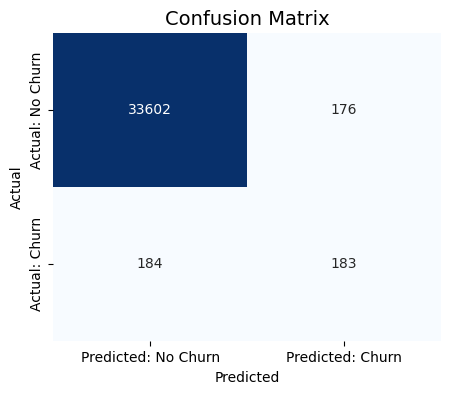

In [ ]:
# Confusion matrix (TP, FP, TN, FN)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize = (5,4))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            xticklabels = ["Predicted: No Churn", "Predicted: Churn"],
            yticklabels = ["Actual: No Churn", "Actual: Churn"])

plt.title("Confusion Matrix", fontsize = 14)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

##### Classification Report

In [ ]:
# Classification report (Precision, Recall, F1, Accuracy by class)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits = 4))


Classification Report:
               precision    recall  f1-score   support

           0     0.9946    0.9948    0.9947     33778
           1     0.5097    0.4986    0.5041       367

    accuracy                         0.9895     34145
   macro avg     0.7522    0.7467    0.7494     34145
weighted avg     0.9893    0.9895    0.9894     34145



##### ROC Curve - AUC Score

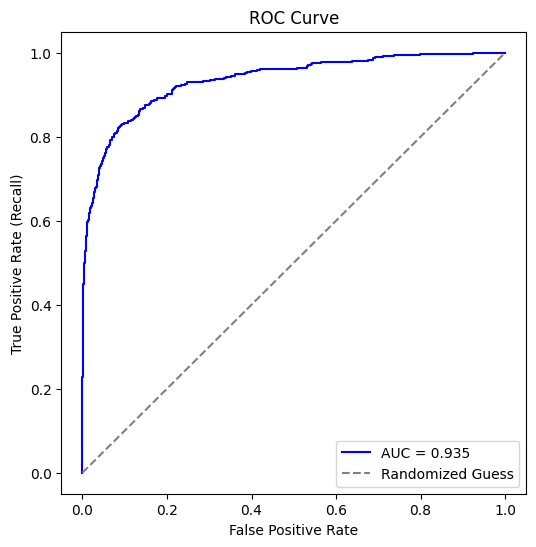

In [ ]:
# Get predicted probabilities for the positive class (churn = 1)
y_prob = final_xgb.predict_proba(X_test)[:, 1]

# Compute False Positive Rate, True Positive Rate and thresholds for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize = (6,6))
plt.plot(fpr, tpr, label = f"AUC = {roc_auc:.3f}", color = "blue")  # model performance
plt.plot([0,1], [0,1], linestyle = "--", color = "gray", label = "Randomized Guess")  # random baseline
plt.xlabel("False Positive Rate")  # x-axis = proportion of non-churners incorrectly predicted as churn
plt.ylabel("True Positive Rate (Recall)")  # y-axis = proportion of churners correctly detected
plt.title("ROC Curve")
plt.legend()
plt.show()

Our model shows strong overall performance in identifying customers at risk of churn. The confusion matrix confirms that we are correctly classifying the vast majority of non-churners, while also detecting a meaningful share of true churners. The classification report further shows that for the minority class, precision (~0.51) and recall (~0.50) are balanced, leading to an F1 score just above 0.50. Finally, the ROC AUC score of 0.935 highlights that the model has excellent discriminative power, meaning it reliably distinguishes churners from non-churners across different probability thresholds.

In practical terms, this means we now have a robust and reliable model that not only achieves high accuracy overall but also provides a realistic balance between false positives and false negatives, which is critical for operational decision-making.

##### Threshold Tuning

At this stage, the model is fully trained with the best hyperparameters we selected through cross-validated tuning. The next step is to focus on threshold tuning. While hyperparameter optimization determined the model’s ability to separate churners from non-churners (the “shape” of the precision–recall curve), adjusting the decision threshold will determine the exact trade-off point we want to operate at.

In other words, threshold tuning does not change the model itself — it simply allows us to decide whether we prefer to minimize false negatives (catching more churners) or to reduce false positives (avoiding wasted resources on non-churners). This choice will depend directly on the company’s business priorities and operational capacity.

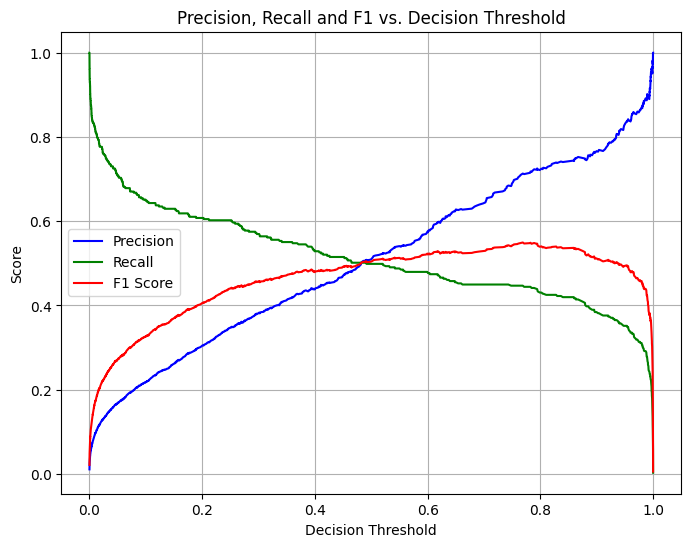

In [ ]:
# Calculate precision, recall and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Plot
plt.figure(figsize = (8,6))
plt.plot(thresholds, precisions[:-1], label = "Precision", color = "blue")
plt.plot(thresholds, recalls[:-1], label = "Recall", color = "green")
plt.plot(thresholds, f1_scores[:-1], label = "F1 Score", color = "red")

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 vs. Decision Threshold")
plt.legend()
plt.grid(True)
plt.show()

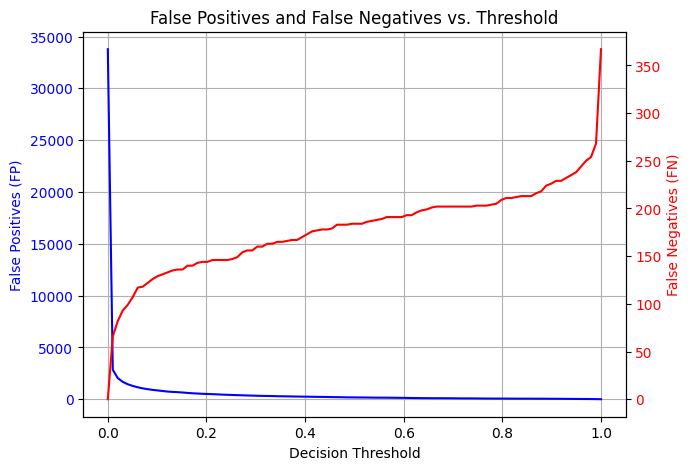

In [ ]:
# Define thresholds
thresholds = np.linspace(0, 1, 100)
fps, fns = [], []

# Loop over thresholds and compute FP/FN
for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    fps.append(fp)
    fns.append(fn)

# Create figure and plot
fig, ax1 = plt.subplots(figsize = (7,5))

# Plot False Positives on the first y-axis (left side)
ax1.plot(thresholds, fps, label = "False Positives (FP)", colo = "blue")
ax1.set_xlabel("Decision Threshold")
ax1.set_ylabel("False Positives (FP)", color = "blue")
ax1.tick_params(axis = 'y', labelcolor = "blue")

# Create second y-axis to plot False Negatives (FN)
ax2 = ax1.twinx()
ax2.plot(thresholds, fns, label = "False Negatives (FN)", colo = "red")
ax2.set_ylabel("False Negatives (FN)", color = "red")
ax2.tick_params(axis = 'y', labelcolor = "red")

# Title and grid
plt.title("False Positives and False Negatives vs. Threshold")
ax1.grid(True)

# Show the plot
plt.show()


After evaluating the trade-off between false positives and false negatives at various decision thresholds, we have identified that a threshold of 0.2 is a key point. Beyond this threshold, the curve for false positives flattens out, showing little incremental gain in reducing them further. On the other hand, we observe a significant increase in the detection of false negatives, which is crucial in churn prediction, where failing to identify potential churn can have a substantial financial impact. Therefore, setting the threshold at 0.2 strikes an optimal balance, minimizing the risk of overlooking churn while maintaining an acceptable level of false positives. This threshold provides the most effective point for our business context.

In [ ]:
# Aplicar el umbral de 0.2 para clasificar las probabilidades como 0 o 1
y_pred_20 = (y_prob >= 0.2).astype(int)

# Generar el classification report
report = classification_report(y_test, y_pred_20, target_names = ["No Churn", "Churn"])

print(report)

              precision    recall  f1-score   support

    No Churn       1.00      0.98      0.99     33778
       Churn       0.30      0.61      0.41       367

    accuracy                           0.98     34145
   macro avg       0.65      0.80      0.70     34145
weighted avg       0.99      0.98      0.98     34145



#### **Final Conclusion**

In conclusion, through a thorough process of hyperparameter optimization, we have successfully identified the optimal combination to achieve a model that is both stable and reliable. The final refinement was made by adjusting the threshold, considering what best serves the business needs. While we acknowledge the tradeoff between proactively identifying churners and the potential cost of incorrectly classifying some as churners, this adjustment enables us to strike a balance between minimizing unnecessary resource allocation for prevention and ensuring timely identification of high-risk churners. This approach provides a robust solution that aligns well with both operational efficiency and business objectives.